# BreakHis Image Classification with 🤗 Vision Transformers and `TensorFlow`

### Quick intro: Vision Transformer (ViT) by Google Brain
The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

* [Original paper](https://arxiv.org/abs/2010.11929)
* [Official repo (in JAX)](https://github.com/google-research/vision_transformer)
* [🤗 Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit)
* [Pre-trained model](https://huggingface.co/google/vit-base-patch16-224-in21k)

## Installation

In [1]:
# !pip install transformers datasets "tensorflow==2.6.0" tensorflow-addons --upgrade

## Setup & Configuration

In this step, we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning process, e.g. `feature extractor` and `model` we will use. 

In this example we are going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.
There are also [large](https://huggingface.co/google/vit-large-patch16-224-in21k) and [huge](https://huggingface.co/google/vit-huge-patch14-224-in21k) flavors of original ViT.

In [45]:
model_id = "google/vit-base-patch16-224-in21k"
zoom = 400


In [46]:
from datasets import load_dataset
from datetime import datetime
import json
from keras.utils import to_categorical
from keras.callbacks import CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import shutil
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import tensorflow as tf
import tensorflow_addons as tfa
from transformers import create_optimizer, DefaultDataCollator, ViTImageProcessor, TFViTForImageClassification


## Dataset & Pre-processing

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

The `BreakHis` is not yet available as a dataset in the `datasets` library. To be able to create a `Dataset` instance we need to write a small little helper function, which will load our `Dataset` from the filesystem and create the instance to use later for training.

This notebook assumes that the dataset is available in directory tree next to this file and its directory name is `breakhis_400x`

In [47]:
now = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
cwd = Path().absolute()
input_path = cwd / f'breakhis_{zoom}x'
output_path = cwd / 'results' / f'{zoom}x_{now}'

output_path

PosixPath('/home/miki/Documents/studia/praca_dyplomowa/vcs/results/400x_2023_04_23-12_09_23')

In [49]:
shutil.rmtree(output_path, ignore_errors=True)
os.makedirs(output_path)

In [50]:
tf.debugging.disable_traceback_filtering()

image_processor = ViTImageProcessor.from_pretrained(model_id)

train_val_test_csv = str(input_path / "train_val_test.csv")

dataset = load_dataset('csv', data_files={'train': train_val_test_csv})


def load_images(file_locs):
    return [Image.open(file_loc).convert("RGB") for file_loc in file_locs]


images = load_images(dataset['train']['file_loc'])


def process_example(image):
    inputs = image_processor(image, return_tensors='tf')
    return inputs['pixel_values']


def process_dataset(example, idx):
    example['pixel_values'] = process_example(images[idx])

    example['label'] = to_categorical(example['label'], num_classes=2)
    return example


dataset = dataset.map(process_dataset, with_indices=True, num_proc=1)

print(dataset)


Found cached dataset csv (/home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-10f81430c6d98183.arrow


DatasetDict({
    train: Dataset({
        features: ['file_loc', 'label', 'patient_id', 'pixel_values'],
        num_rows: 1820
    })
})


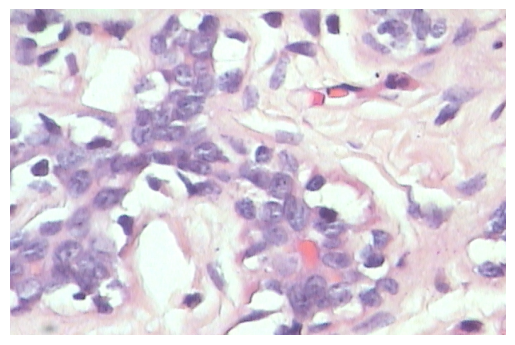

In [52]:
pth = dataset['train']["file_loc"][0]
img = Image.open(pth).convert("RGB")
pxl = process_example(img)

plt.imshow(img)
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


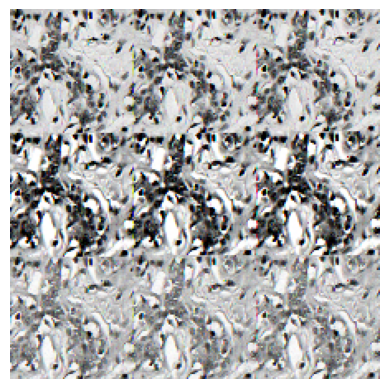

In [53]:
plt.imshow(np.array(pxl).reshape(224, 224, 3))
plt.axis('off')
plt.show()


In [54]:
image_processor(img, return_tensors='tf')


{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[0.654902  , 0.6156863 , 0.5058824 , ..., 0.7882353 ,
          0.77254903, 0.7647059 ],
         [0.6392157 , 0.58431375, 0.43529415, ..., 0.77254903,
          0.77254903, 0.7647059 ],
         [0.62352943, 0.5294118 , 0.43529415, ..., 0.7647059 ,
          0.77254903, 0.7411765 ],
         ...,
         [0.84313726, 0.8509804 , 0.8509804 , ..., 0.70980394,
          0.73333335, 0.7411765 ],
         [0.8509804 , 0.85882354, 0.85882354, ..., 0.73333335,
          0.75686276, 0.79607844],
         [0.85882354, 0.85882354, 0.8509804 , ..., 0.75686276,
          0.6313726 , 0.7254902 ]],

        [[0.70980394, 0.62352943, 0.48235297, ..., 0.69411767,
          0.654902  , 0.6627451 ],
         [0.67058825, 0.56078434, 0.39607847, ..., 0.69411767,
          0.654902  , 0.6627451 ],
         [0.6313726 , 0.4901961 , 0.37254906, ..., 0.6862745 ,
          0.654902  , 0.6392157 ],
         ...,
         [0.8

In [55]:
dataset['train'][0]


{'file_loc': 'breakhis_400x/benign/SOB_B_TA-14-13200-400-014.png',
 'label': [1.0, 0.0],
 'patient_id': 'SOB_B_TA-14-13200',
 'pixel_values': [[[[0.6549019813537598,
     0.615686297416687,
     0.5058823823928833,
     0.49803924560546875,
     0.545098066329956,
     0.5843137502670288,
     0.6470588445663452,
     0.6705882549285889,
     0.6627451181411743,
     0.686274528503418,
     0.6078431606292725,
     0.21568632125854492,
     -0.011764705181121826,
     -0.019607841968536377,
     0.12941181659698486,
     0.24705886840820312,
     0.2549020051956177,
     0.30980396270751953,
     0.27843141555786133,
     0.34117650985717773,
     0.5137255191802979,
     0.615686297416687,
     0.6627451181411743,
     0.686274528503418,
     0.7098039388656616,
     0.772549033164978,
     0.7647058963775635,
     0.7568627595901489,
     0.7568627595901489,
     0.7490196228027344,
     0.7490196228027344,
     0.7647058963775635,
     0.7568627595901489,
     0.7568627595901489,
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


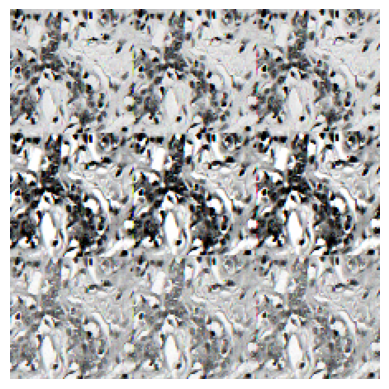

In [56]:
plt.imshow(np.array(dataset['train'][0]['pixel_values']).reshape(224, 224, 3))
plt.axis('off')
plt.show()


Since our dataset doesn't includes any split we need to `train_test_split` ourself to have an evaluation/test dataset for evaluating the result during and after training. 

## Fine-tuning the model using `Keras`

Now that our `dataset` is processed, we can download the pretrained model and fine-tune it. But before we can do this we need to convert our Hugging Face `datasets` Dataset into a `tf.data.Dataset`. For this, we will use the `.to_tf_dataset` method and a `data collator` (Data collators are objects that will form a batch by using a list of dataset elements as input).




## Hyperparameter

In [57]:
id2label = {"0": "benign", "1": "malignant"}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 10
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0
output_dir = model_id.split("/")[1]
fp16 = True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")


### Download the pretrained transformer model and fine-tune it. 

In [58]:
# define loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# define metrics
metrics = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name='auc', from_logits=True),
    tf.keras.metrics.AUC(name='auc_multi', from_logits=True, num_labels=2, multi_label=True),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision'),
    tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5),
]

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3),
    CSVLogger(output_path / f'train_metrics.csv')
]

def train_model(train, val):
    num_train_steps = len(train) * num_train_epochs
    print(f"num_train_steps = {num_train_steps}")
    optimizer, _ = create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        weight_decay_rate=weight_decay_rate,
        num_warmup_steps=num_warmup_steps,
    )

    # load pre-trained ViT model
    model = TFViTForImageClassification.from_pretrained(
        model_id,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
    )

    # compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train,
        validation_data=val,
        callbacks=callbacks,
        epochs=num_train_epochs,
    )

    return {
        'model': model,
        'history': history
    }


In [59]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_val_data = dataset['train']
files = np.array(train_val_data['file_loc'])
labels = np.array(train_val_data['label'])
patient_ids = np.array(train_val_data['patient_id'])


In [60]:
train_val_test_split = GroupShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42)
train_val_index, test_index = next(
    train_val_test_split.split(files, labels, patient_ids))


def filter_train_val_indices(idx, indices):
    return idx in indices


train_val_files = files[train_val_index]
train_val_labels = labels[train_val_index]
train_val_patient_ids = patient_ids[train_val_index]

n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)


def remove_extra_dim(example):
    example['pixel_values'] = np.squeeze(example['pixel_values'], axis=0)
    return example


In [61]:
models_with_histories = []
folds = group_kfold.split(
    train_val_files, train_val_labels, train_val_patient_ids)


def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def run_fold(idx):
    (train_index, val_index) = next(folds)

    # Check indices uniqueness
    train_index_unique, train_counts = np.unique(
        train_index, return_counts=True)
    val_index_unique, val_counts = np.unique(val_index, return_counts=True)
    are_all_values_unique = np.all(
        train_counts == 1) and np.all(val_counts == 1)

    print('Are all indices', are_all_values_unique)
    print(
        f'Indices shared between train & val splits (should be empty): {intersection(train_index_unique, val_index_unique)}')

    # Check patient ids uniqueness
    train_data_filtered = train_val_data.filter(lambda _, idx: filter_train_val_indices(
        idx, train_index), with_indices=True).map(remove_extra_dim)
    val_data_filtered = train_val_data.filter(lambda _, idx: filter_train_val_indices(
        idx, val_index), with_indices=True).map(remove_extra_dim)

    train_ids_unique, train_counts = np.unique(
        train_data_filtered['patient_id'], return_counts=True)
    val_ids_unique, val_counts = np.unique(
        val_data_filtered['patient_id'], return_counts=True)
    are_all_values_unique = np.all(
        train_counts == 1) and np.all(val_counts == 1)

    print(f'Train patient IDs: {len(train_ids_unique)}')
    print(f'Test patient IDs: {len(val_ids_unique)}')
    print(
        f'Train + Test patient IDs: {len(train_ids_unique) + len(val_ids_unique)}')
    print(
        f'Patient IDs shared between train & val splits (should be empty): {intersection(train_ids_unique, val_ids_unique)}')

    # Create datasets and train model
    train_dataset = train_data_filtered.to_tf_dataset(
        columns=['pixel_values'],
        label_cols=['label'],
        shuffle=True,
        batch_size=train_batch_size,
        collate_fn=data_collator
    )

    val_dataset = val_data_filtered.to_tf_dataset(
        columns=['pixel_values'],
        label_cols=['label'],
        shuffle=True,
        batch_size=eval_batch_size,
        collate_fn=data_collator
    )
    print(train_dataset)
    print(val_dataset)

    model_with_history = train_model(train_dataset, val_dataset)
    model_with_history['patient_ids'] = {
        'train': list(train_ids_unique), 'val': list(val_ids_unique)}

    models_with_histories.append(model_with_history)

    print(f'Fold {idx + 1}/{n_splits} finished')


In [62]:
run_fold(0)


Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-399096e4f54fabe0.arrow
Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-10520befedca7aa5.arrow
Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-aaaad646672c16ff.arrow
Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1a3d557d7639be26.arrow


Are all indices True
Indices shared between train & val splits (should be empty): []
Train patient IDs: 82
Test patient IDs: 72
Train + Test patient IDs: 154
Patient IDs shared between train & val splits (should be empty): ['SOB_B_PT-14-21998AB', 'SOB_M_DC-14-2523', 'SOB_M_DC-14-5287', 'SOB_M_DC-14-17915', 'SOB_B_F-14-14134', 'SOB_M_DC-14-16448', 'SOB_M_PC-14-19440', 'SOB_M_DC-14-18650', 'SOB_B_F-14-23060CD', 'SOB_M_PC-14-15704', 'SOB_B_TA-14-19854C', 'SOB_M_DC-14-15696', 'SOB_M_DC-14-15792', 'SOB_M_LC-14-15570C', 'SOB_B_F-14-14134E', 'SOB_M_DC-14-20636', 'SOB_B_TA-14-21978AB', 'SOB_M_DC-14-11520', 'SOB_B_PT-14-29315EF', 'SOB_M_DC-14-9461', 'SOB_M_DC-14-17901', 'SOB_B_F-14-9133', 'SOB_M_MC-14-12773', 'SOB_M_DC-14-15572', 'SOB_B_TA-14-15275', 'SOB_M_MC-14-18842D', 'SOB_M_DC-14-16875', 'SOB_B_A-14-22549CD', 'SOB_M_DC-14-4364', 'SOB_B_F-14-29960AB', 'SOB_M_DC-14-2773', 'SOB_M_MC-14-16456', 'SOB_M_DC-14-3909', 'SOB_B_TA-14-16184CD', 'SOB_B_F-14-25197', 'SOB_M_DC-14-11951', 'SOB_M_DC-14-149

In [ ]:
run_fold(1)


In [ ]:
run_fold(2)


In [ ]:
run_fold(3)


In [ ]:
run_fold(4)


### Dump histories

In [22]:
for idx, model_with_history in enumerate(models_with_histories):
    history = model_with_history.get('history', None)
    np.save(output_path / f'train_history_{idx}.npy', history.history)

# To load:
# history = np.load(output_path / f'train_history_{idx}.npy', allow_pickle='TRUE').item()


In [37]:

for idx, model_with_history in enumerate(models_with_histories):
    model = model_with_history.get('model', None)
    model.save_pretrained(output_path / f'model_{idx}', from_tf=True) 


In [42]:
for idx in range(len(models_with_histories)):
    loaded_model = model = TFViTForImageClassification.from_pretrained(output_path / f'model_{idx}')
    optimizer, _ = create_optimizer(
        init_lr=learning_rate,
        num_train_steps=360, # TODO save this number during training
        weight_decay_rate=weight_decay_rate,
        num_warmup_steps=num_warmup_steps,
    )
    loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at /home/miki/Documents/studia/praca_dyplomowa/breakhis/output/model_0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [63]:
def remove_extra_dim(example):
    example['pixel_values'] = np.squeeze(example['pixel_values'], axis=0)
    return example


test_dataset = train_val_data.filter(
    lambda _, idx: filter_train_val_indices(idx, test_index), with_indices=True)

test_dataset = test_dataset.map(remove_extra_dim)

test_ids_unique = list(np.unique(test_dataset['patient_id']))

test_dataset = test_dataset.to_tf_dataset(
    columns=['pixel_values'],
    label_cols=["label"],
    shuffle=False,
    batch_size=eval_batch_size,
    collate_fn=data_collator)

# for model in models_with_histories:
# Wybierz najlepszy model z walidacji, przykład:
# best_model = models_with_histories[0].get('model', None)
best_model = loaded_model

# Ewaluacja na zbiorze testowym
results = best_model.evaluate(test_dataset)

# Wypisanie wyników ewaluacji
print("Test dataset evaluation results:")
for metric, value in zip(best_model.metrics_names, results):
    print(f"{metric}: {value}")


Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0a30aa337e269cb0.arrow
Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-0cdfc0a9a773f165/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-2b219b887e531853.arrow


In [44]:
preds = best_model.predict(test_dataset)
probabilities = tf.nn.softmax(preds.logits, axis=-1)


12/12 [==============================] - 12s 776ms/step


In [45]:
labels_pred = np.argmax(probabilities, axis=-1)
labels_pred


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
np.array(test_dataset['label'])


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [65]:
patient_ids_per_fold = {}
for idx, model_with_history in enumerate(models_with_histories):
    patient_ids = model_with_history.get('patient_ids')
    patient_ids_per_fold[f'fold_{idx}'] = patient_ids

patient_ids_per_fold['test'] = test_ids_unique

patient_ids_per_fold
with open(output_path / 'patient_ids.json', 'w') as patient_ids_json:
    json.dump(patient_ids_per_fold, patient_ids_json, indent = 4)

In [47]:
# Extract file locations and real labels from the test dataset
file_locs = [example['file_loc'] for example in test_dataset]
labels = [np.argmax(example['label']) for example in test_dataset]

# Create a DataFrame
results_df = pd.DataFrame(
    {'file_loc': file_locs, 'label': labels, 'label_pred': labels_pred})

# Save the DataFrame as a CSV file
results_df.to_csv(output_path / f'test_results.csv', index=False)


In [28]:
correct_predictions = np.sum(results_df['label'] == results_df['label_pred'])

# Calculate the total number of predictions
total_predictions = len(results_df)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print("Manual accuracy calculation:", accuracy)


Manual accuracy calculation: 0.9817232375979112
